<a href="https://colab.research.google.com/github/davifcs/ia376/blob/main/Aula_7_OCR_Fim_a_fim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enunciado

O objetivo deste exercício é treinar uma rede similar à da aula 6 (CNN como codificadora + decodificador do transformer) mas tendo como entrada a *imagem* do texto da legenda. A saída esperada é o texto que está na imagem. 

Iremos usar o dataset do MS COCO e converter as legendas como imagens.
No MS COCO, existem 5 legendas para cada imagem. Iremos usar cada uma das legendas como um único exemplo. Portanto, é como se o dataset de treino e teste ficassem 5x maiores.
Note que não iremos usar as imagem originais do MS COCO neste exercicício.

Métricas: usar o código abaixo para calcular o exact match da sentença toda e F1 de palavras.

Um código exemplo para converter texto para imagem é fornecido abaixo.

## MS COCO reduzido (23k exemplos de treino)

Download do dataset MS COCO reduzido para 23k exemplos:

In [1]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/*_CAPTIONS_coco_5_cap_per_img.json .

Skipping existing item: file://./TEST_CAPTIONS_coco_5_cap_per_img.json
Skipping existing item: file://./TRAIN_CAPTIONS_coco_5_cap_per_img.json
Skipping existing item: file://./VAL_CAPTIONS_coco_5_cap_per_img.json


O dataset deve conter 23.520, 1.052 e 1.047 imagens de treino, validação e teste.

## (Opcional) MS COCO completo (113k exemplos de treino)

Download do dataset MS COCO completo.

In [2]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula6/*_CAPTIONS_coco_5_cap_per_img.json .

Skipping existing item: file://./TEST_CAPTIONS_coco_5_cap_per_img.json
Skipping existing item: file://./VAL_CAPTIONS_coco_5_cap_per_img.json
Skipping existing item: file://./TRAIN_CAPTIONS_coco_5_cap_per_img.json


O dataset deve conter 113.287, 5.000 e 5.000 imagens de treino, validação e teste.

## Conversão de Texto para Imagem

In [3]:
!pip install efficientnet-pytorch transformers
!pip install tdqm
!pip install pytorch-lightning 

Precisamos primeiramente fazer download da font arial.

In [4]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula7/arial.ttf .

Skipping existing item: file://./arial.ttf


O código abaixo converte um texto para imagem:

In [5]:
import h5py
import json
import os
import nvidia_smi

from google.colab import drive

import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule 
from pytorch_lightning.callbacks import ModelCheckpoint

import torchvision
from torchvision import transforms
from torch.optim import lr_scheduler
from torchsummary import summary 

import efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer

import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

from collections import OrderedDict

import matplotlib.pyplot as plt

In [6]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [7]:
# Configurações gerais

ENCODER = 'efficientnet-b0'
DECODER = 't5-small'
BATCH_SIZE = 32
NUM_WORKERS = 2
accumulate_grad_batches = 2
LEARNING_RATE = 1e-3

device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')

In [8]:
print(f"Pytorch Lightning Version: {pl.__version__}")
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

def gpu_usage():
    global handle
    return str(nvidia_smi.nvmlDeviceGetUtilizationRates(handle).gpu) + '%'

Pytorch Lightning Version: 1.0.5
Device name: b'Tesla T4'


In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
train_captions = json.load(open("/content/TRAIN_CAPTIONS_coco_5_cap_per_img.json"))

val_captions = json.load(open("/content/VAL_CAPTIONS_coco_5_cap_per_img.json"))

test_captions = json.load(open("/content/TEST_CAPTIONS_coco_5_cap_per_img.json"))

In [11]:
tokenizer = T5Tokenizer.from_pretrained(DECODER)

class MSCOCODataset(Dataset):
    def __init__(self,  
                 path_captions,
                 transform = None,
                 seq_max_length: int = 64):
        self.captions = path_captions
        self.transform = transform
        self.tokenizer = tokenizer
        self.seq_max_length = seq_max_length

    def _text_to_image(self, text: str, max_width: int, max_height: int):
      image = Image.new('RGB', (max_width, max_height), (0, 0, 0))  # Black background.
      d = ImageDraw.Draw(image)
      
      d.text((10, 0), text, font=ImageFont.truetype("arial.ttf", 28), fill=(255, 255, 255))  # Texto começa na posicão x=10, y=0.
      
      text_width, text_height = d.textsize(text)  # Caso queria saber o tamanho do texto.
      
      return np.array(image)

    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        caption = self.captions[idx][0]
        image = self._text_to_image(text=caption, max_width=832, max_height=32)
        
        # image = torch.from_numpy(image.transpose(2, 0, 1))
        image = np.moveaxis(image, 2, 0).astype(float)

        tokenized_caption = self.tokenizer.encode_plus(caption, 
                                         max_length=self.seq_max_length, 
                                         padding='max_length', 
                                         truncation=True, 
                                         return_tensors='pt')
        
        caption_token_ids = tokenized_caption['input_ids'].squeeze(0)

        if self.transform is not None:
          image = self.transform(image)

        return image, caption, caption_token_ids

In [12]:
transform = transforms.Compose([transforms.Lambda(lambda img: img * 2.0 - 1.0),])

dataset_debug = MSCOCODataset(train_captions, transform=transform)


debug_dataloader = DataLoader(dataset_debug, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=NUM_WORKERS)

train_set = MSCOCODataset(train_captions, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True,  num_workers=NUM_WORKERS)

val_set = MSCOCODataset(val_captions, transform=transform)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

test_set = MSCOCODataset(test_captions, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


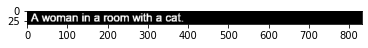

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


A woman in a room with a cat.
tensor([  71, 2335,   16,    3,    9,  562,   28,    3,    9, 1712,    5,    1,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


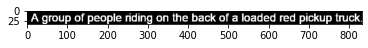

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


A group of people riding on the back of a loaded red pickup truck.
tensor([   71,   563,    13,   151,  7494,    30,     8,   223,    13,     3,
            9, 10346,  1131, 12820,  4072,     5,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


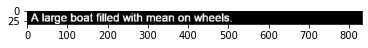

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


A large boat filled with mean on wheels.
tensor([  71,  508, 3432, 3353,   28, 1243,   30, 8277,    5,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


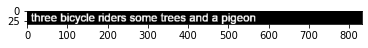

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


three bicycle riders some trees and a pigeon
tensor([  386, 12679, 14149,   128,  3124,    11,     3,     9,     3,  9905,
           15,   106,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


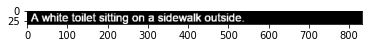

A white toilet sitting on a sidewalk outside.
tensor([   71,   872,  6699,  3823,    30,     3,     9, 21393,  1067,     5,
            1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [13]:
SAMPLES = 4

for i in range(0, SAMPLES+1):
  image, caption, tokens = train_set[i]
  image = np.moveaxis(image, 0, 2)

  plt.imshow(image)
  plt.show()
  print(caption)
  print(tokens)


In [14]:
class Captioning(LightningModule):
    def __init__(self, train_dataloader, val_dataloader, test_dataloader, 
                 learning_rate, seq_max_length=64):
        super(Captioning, self).__init__()
        
        self._train_dataloader = train_dataloader

        self._val_dataloader = val_dataloader

        self._test_dataloader = test_dataloader

        self.learning_rate = learning_rate

        self.encoder = EfficientNet.from_pretrained(ENCODER, advprop=True)

        # for param in self.encoder.parameters(): 
        #     param.requires_grad = False

        self.decoder = T5ForConditionalGeneration.from_pretrained(DECODER)

        self.cnn = nn.Conv2d(in_channels=112,
                              out_channels=self.decoder.config.d_model,
                              kernel_size=1)
        
        self.seq_max_length = seq_max_length
        
    def forward(self, images, labels=None):
        features = self.encoder.extract_endpoints(images.float())["reduction_4"]  # (batch_size, 1280, image_size, image_size)
        features = self.cnn(features) # (batch_size, decoder_size, image_size, image_size)
        # features = features.permute(0, 2, 3, 1).reshape(features.shape[0], -1, self.decoder.config.d_model)
        features = features.view(features.size(0), -1, features.size(1)) # (batch_size, encoded_image_size, decoder_size)

        if self.training:
          loss = self.decoder(inputs_embeds=features, labels=labels)[0]
          return loss

        else:
          decoded_ids = torch.full((features.shape[0], 1), 
                                   model.decoder.config.decoder_start_token_id, 
                                   dtype=torch.long).to(device) 
          
          encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=features)

          for i in range(self.seq_max_length):
            logits = self.decoder(encoder_outputs=encoder_hidden_states, 
                                  decoder_input_ids=decoded_ids)[0]
            next_token_logits = logits[:, -1, :]
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                      
            if torch.eq(next_token_id[:, -1], self.decoder.config.eos_token_id).all():
              break
          
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

          return decoded_ids

    def training_step(self, batch, batch_idx):
      images, captions, caption_tokens = batch
      train_loss = self(images, caption_tokens)
      return train_loss

    def validation_step(self, batch, batch_idx):
      images, captions, _ = batch
      predicted_tokens = self(images)
      predicted_captions = [tokenizer.decode(tokens) for tokens in predicted_tokens]

      return {"predicted_captions": predicted_captions, "captions": captions}

    def test_step(self, batch, batch_idx):
      images, captions, _ = batch
      predicted_tokens = self(images)
      predicted_captions = [tokenizer.decode(tokens) for tokens in predicted_tokens]

      return {"predicted_captions": predicted_captions, "captions": captions}

    def validation_epoch_end(self, outputs):
      predicted_captions = sum([list(x["predicted_captions"]) for x in outputs], [])
      captions = sum([list(x["captions"]) for x in outputs], [])
      
      print("Validation - Caption: ",captions[0])
      print("Validation - Predicted: ",predicted_captions[0])

      f1 = []
      exact = []
      for predicted_caption, caption in zip(predicted_captions, captions):
        f1.append(compute_f1(a_gold=caption, a_pred=predicted_caption))
        exact.append(compute_exact(a_gold=caption, a_pred=predicted_caption))
      f1 = np.mean(f1)
      exact = np.mean(exact)
      self.log("Validation F1", f1, prog_bar=True)
      self.log("Validation Exact", exact, prog_bar=True)

    def test_epoch_end(self, outputs):
      predicted_captions = sum([list(x["predicted_captions"]) for x in outputs], [])
      captions = sum([list(x["captions"]) for x in outputs], [])

      print("Test - Caption: ",captions[0])
      print("Test - Predicted: ",predicted_captions[0])

      f1 = []
      exact = []
      for predicted_caption, caption in zip(predicted_captions, captions):
        f1.append(compute_f1(a_gold=caption, a_pred=predicted_caption))
        exact.append(compute_exact(a_gold=caption, a_pred=predicted_caption))
      f1 = np.mean(f1)
      exact = np.mean(exact)
      self.log("Test F1", f1, prog_bar=True)
      self.log("Test Exact", exact, prog_bar=True)

    def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
      return self._train_dataloader

    def val_dataloader(self):
      return self._val_dataloader

    def test_dataloader(self):
      return self._test_dataloader



In [15]:
model = Captioning(train_dataloader = train_loader,
            val_dataloader = val_loader,
            test_dataloader = test_loader,
            learning_rate=LEARNING_RATE)

trainer = pl.Trainer(gpus=1, 
                     checkpoint_callback=False,  # Disable checkpoint saving.
                     fast_dev_run=True)
trainer.fit(model)
trainer.test(model)

del model # Para não ter estouro de mémoria da GPU

Loaded pretrained weights for efficientnet-b0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5 M   
1 | decoder | T5ForConditionalGeneration | 60 M  
2 | cnn     | Conv2d                     | 57 K  


Validation - Caption:  Girl in a tank top holding a kitten in her back yard
Validation - Predicted:  i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i



Test - Caption:  A large jetliner sitting on top of an airport runway.
Test - Predicted:  i y i y i y i i i i i i i i i i i i i i i i i i i i i i i i i i
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test Exact': 0.0, 'Test F1': 0.00625}
--------------------------------------------------------------------------------



In [16]:
trainer = pl.Trainer(gpus=1,
                     max_epochs=100,
                     check_val_every_n_epoch=20,
                     checkpoint_callback=False,  # Disable checkpoint saving
                     overfit_batches=1)

model = Captioning(train_dataloader=debug_dataloader,
                    val_dataloader=debug_dataloader,
                    test_dataloader=None,
                    learning_rate=LEARNING_RATE)

trainer.fit(model)
del model  # Para não ter estouro de mémoria da GPU

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded pretrained weights for efficientnet-b0



  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5 M   
1 | decoder | T5ForConditionalGeneration | 60 M  
2 | cnn     | Conv2d                     | 57 K  


Validation - Caption:  A woman in a room with a cat.
Validation - Predicted:  d d                                                            


Validation - Caption:  A woman in a room with a cat.
Validation - Predicted:  


Validation - Caption:  A woman in a room with a cat.
Validation - Predicted:  A group of people walk alongside the road.


Validation - Caption:  A woman in a room with a cat.
Validation - Predicted:  A group of people riding on the back of a loaded red pickup truck.


Validation - Caption:  A woman in a room with a cat.
Validation - Predicted:  A group of people walk alongside the road.


Validation - Caption:  A woman in a room with a cat.
Validation - Predicted:  A group of people walk alongside the road.



In [17]:
max_epochs = 5
 
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/epoch=20.ckpt'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
print(f'Saving checkpoints to {checkpoint_dir}')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_dir,
                                      save_top_k=-1)  # Keeps all checkpoints.
 
resume_from_checkpoint = None
if os.path.exists(checkpoint_path):
    print(f'Restoring checkpoint: {checkpoint_path}')
    resume_from_checkpoint = checkpoint_path
 
trainer = pl.Trainer(gpus=1,
                     max_epochs=max_epochs,
                     check_val_every_n_epoch=1,
                     profiler=True,
                     accumulate_grad_batches=accumulate_grad_batches,
                     checkpoint_callback=checkpoint_callback,
                     progress_bar_refresh_rate=50,
                     resume_from_checkpoint=resume_from_checkpoint)

model = Captioning(train_dataloader = train_loader,
                   val_dataloader = val_loader,
                   test_dataloader = test_loader,
                   learning_rate=LEARNING_RATE)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files in /content/drive/My Drive/Colab Notebooks: ['Cópia de Copy of Explorando-Convolucao-no-PyTorch (1).ipynb', 'Cópia de Copy of Explorando-Convolucao-no-PyTorch.ipynb', 'Cópia de Copy of cifar10-CNN-features (1).ipynb', 'Cópia de Copy of Introducao-CNN-PyTorch.ipynb', 'Cópia de Copy of cifar10-CNN-features.ipynb', 'Cópia de Aula 1 - Classificação de Imagens.ipynb', 'Untitled', 'Davi Santos - Atividade Aula2 - Notebook 2.ipynb', 'Davi Santos - Atividade Aula2 - Notebook 1.ipynb', 'Cópia de Aula3 - Básico - Auto-Atenção - Template.ipynb', '.ipynb_checkpoints', 'Aula3-Basico-Auto-Atencao.pdf', 'Aula3-Básico-Auto-Atencao.ipynb', 'Cópia de Aula3-Básico-Auto-Atencao.ipynb', 'Aula 4 - Basico - Auto Atencao Completa.pdf', 'Aula 4 - Basico - Auto Atencao Completa.ipynb', 'epoch=0.ckpt', 'epoch=0-v0.ckpt', 'epoch=0-v1.ckpt', 'epoch=0-v2.ckpt', 'epoch=0-v3.ckpt', 'epoch=0-v4.ckpt', 'epoch=0-v5.ckpt', 'epoch=1.ckpt', 'epoch=2.ckpt', 'epoch=0-v6.ckpt', 'epoch=1-v0.ckpt', 'epoch=2


  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5 M   
1 | decoder | T5ForConditionalGeneration | 60 M  
2 | cnn     | Conv2d                     | 57 K  


Validation - Caption:  Girl in a tank top holding a kitten in her back yard
Validation - Predicted:  


Validation - Caption:  Girl in a tank top holding a kitten in her back yard
Validation - Predicted:  a man is riding a horse in the grass with a dog on it


Validation - Caption:  Girl in a tank top holding a kitten in her back yard
Validation - Predicted:  Cat sitting on a couch with a teddy bear on it.


Validation - Caption:  Girl in a tank top holding a kitten in her back yard
Validation - Predicted:  Cat sitting on a chair with a laptop computer.


Validation - Caption:  Girl in a tank top holding a kitten in her back yard
Validation - Predicted:  Old fashioned truck parked in a parking lot


Validation - Caption:  Girl in a tank top holding a kitten in her back yard
Validation - Predicted:  Older truck parked in a parking lot with a car




Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_fit_start        	|  3.1207e-05     	|  3.1207e-05     
on_validation_start 	|  0.027798       	|  0.16679        
on_validation_epoch_start	|  2.9716e-05     	|  0.00017829     
on_validation_batch_start	|  3.0028e-05     	|  0.0050147      
validation_step_end 	|  3.1092e-05     	|  0.0051924      
on_validation_batch_end	|  2.91e-05       	|  0.0048597      
on_validation_epoch_end	|  3.4474e-05     	|  0.00020684     
on_validation_end   	|  5.1165         	|  30.699         
on_train_start      	|  0.057476       	|  0.057476       
on_epoch_start      	|  0.0032508      	|  0.016254       
on_train_epoch_start	|  1.6739e-05     	|  8.3697e-05     
get_train_batch     	|  0.0040475      	|  14.875         
on_batch_start      	|  4.0814e-05     	|  0.14999        
on_train_batch_start	|  1.5778e-05     	|  0.057985       
training_ste

1

In [18]:
trainer.test(model)

Test - Caption:  A large jetliner sitting on top of an airport runway.
Test - Predicted:  A large jetliner flying through a cloudy blue sky.
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test Exact': 0.0, 'Test F1': 0.3540972636683279}
--------------------------------------------------------------------------------



[{'Test Exact': 0.0, 'Test F1': 0.3540972636683279}]